Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles, Lakshminarayanan et al.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
import itertools
import importlib

import sys
sys.path.append("..")
from training import ensemble

In [9]:
# 3.2: Regression on toy datasets

from training import toy
importlib.reload(toy)


torch.manual_seed(42)
device = torch.device("cpu")

batch_size = 2

trainset = toy.CubicToyDataset(min=-4, max=4, sample_count=20, noise=3, normalize=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

In [14]:
def nll_adversarial_ensemble(nets, adversarial_training):
    torch.manual_seed(42)

    def nll_loss(mean, variance, target):
        return (torch.log(variance) / 2 + torch.pow(target - mean, 2) / (2 * variance)).sum() / mean.shape[0]

    models = [nn.Sequential(
        nn.Linear(1, 100), 
        nn.ReLU(), 
        nn.Linear(100, 2)
    ) for _ in range(nets)]

    for i, model in enumerate(models):
        print(f"Training model {i}")
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        for epoch in range(160):
            epoch_loss = torch.tensor(0, dtype=torch.float)
            for data, target in trainloader:
                optimizer.zero_grad()
                if adversarial_training:
                    data.requires_grad = True

                output = model(data)
                mean, variance = output[:, 0], torch.log1p(torch.exp(output[:, 1])) + 1e-6
                loss = nll_loss(mean, variance, target)

                if adversarial_training:
                    loss.backward(retain_graph=True)
                    a_data = data + 0.01 * torch.sign(data.grad)
                    optimizer.zero_grad()
                    a_output = model(data)
                    a_mean, a_variance = a_output[:, 0], torch.log1p(torch.exp(a_output[:, 1])) + 1e-6
                    a_loss = nll_loss(a_mean, a_variance, target)
                    loss += a_loss

                loss.backward()
                optimizer.step()
                epoch_loss += loss
            if epoch % 100 == 0:
                print(f"  Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
        print(f"  Final loss {epoch_loss / (len(trainloader) * batch_size)}")


    def eval_esemble(input):
        return ensemble.combined_variance_output(input, models)
    trainset.plot(eval_esemble)

Training model 0
  Epoch 0: loss 0.8376924395561218
  Epoch 100: loss 0.006785249803215265
  Final loss 0.0023735007271170616
Training model 1
  Epoch 0: loss 0.4603343904018402
  Epoch 100: loss 0.049375321716070175
  Final loss 0.002967919921502471
Training model 2
  Epoch 0: loss 0.5565820932388306
  Epoch 100: loss 0.002576354891061783
  Final loss 0.004141994286328554
Training model 3
  Epoch 0: loss 0.3064808249473572
  Epoch 100: loss 0.003162096720188856
  Final loss 0.007778575178235769
Training model 4
  Epoch 0: loss 0.7642939686775208
  Epoch 100: loss 0.008154617622494698
  Final loss 0.005955883767455816
RMSE 147.6328887939453


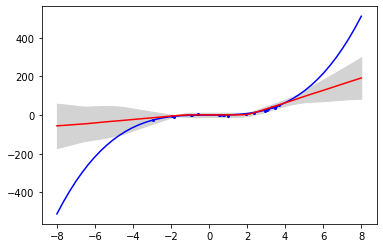

In [15]:
# 5 nets using MSE

torch.manual_seed(42)

ensemble_count = 5
models = [nn.Sequential(
    nn.Linear(1, 100), 
    nn.ReLU(), 
    nn.Linear(100, 1)
) for _ in range(ensemble_count)]

for i, model in enumerate(models):
    print(f"Training model {i}")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    for epoch in range(160):
        epoch_loss = torch.tensor(0, dtype=torch.float)
        for data, target in trainloader:
            optimizer.zero_grad()
            output = model(data)
            loss = F.mse_loss(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss
        if epoch % 100 == 0:
            print(f"  Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
    print(f"  Final loss {epoch_loss / (len(trainloader) * batch_size)}")


def eval_esemble(input):
    outputs = torch.stack([model(input) for model in models])
    return torch.mean(outputs, dim=0), torch.var(outputs, dim=0)
trainset.plot(eval_esemble)

Training model 0
  Epoch 0: loss 4.838761806488037
  Epoch 100: loss -0.6738755106925964
  Final loss -0.7429972887039185
RMSE 200.02777099609375


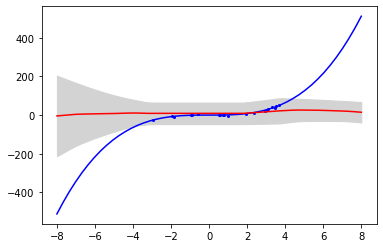

In [18]:
# Single net using NLL

nll_adversarial_ensemble(1, False)

Training model 0
  Epoch 0: loss 9.677512168884277
  Epoch 100: loss -1.3475040197372437
  Final loss -1.486000895500183
RMSE 199.8775177001953


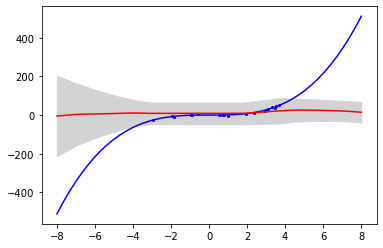

In [19]:
# Single net using NLL and adversarial training

nll_adversarial_ensemble(1, True)

Training model 0
  Epoch 0: loss 6.345309734344482
  Epoch 100: loss -1.2455806732177734
  Final loss -1.5851962566375732
Training model 1
  Epoch 0: loss 9.820246696472168
  Epoch 100: loss -1.2881946563720703
  Final loss -1.399369716644287
Training model 2
  Epoch 0: loss 22.422237396240234
  Epoch 100: loss -1.3349392414093018
  Final loss -1.7012485265731812
Training model 3
  Epoch 0: loss 9.646577835083008
  Epoch 100: loss -1.319692850112915
  Final loss -1.4494715929031372
Training model 4
  Epoch 0: loss 38.235069274902344
  Epoch 100: loss -1.3283700942993164
  Final loss -1.346350908279419
RMSE 165.57167053222656


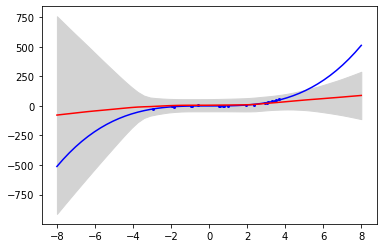

In [20]:
# 5 nets using NLL and adversarial training
nll_adversarial_ensemble(5, True)